In [23]:
#!pip install sentence_transformers
#!pip install --upgrade jupyterlab_widgets
#!jupyter lab build
!pip install python-Levenshtein


   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ------------------------ --------------- 61.4/98.5 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 98.5/98.5 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ----------------------- ---------------- 1.0/1.6 MB 30.7 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 25.6 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein
import re
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [11]:
## Functions for preprocessing

# Function to calculate structural complexity
def length(text):
    return len(text.split())

# Function to calculate Levenshtein distance
def calculate_levenshtein(prompt, result):
    return Levenshtein.distance(prompt, result)

def structural_complexity(text):
    num_commas = text.count(',')
    num_periods = text.count('.')
    num_words = len(text.split())

    # Avoid division by zero by handling edge cases
    average_sentence_length = num_words / num_periods if num_periods > 0 else num_words
    number_of_subsentences = num_commas

    # Determine structural complexity score based on criteria
    if average_sentence_length < 10 and number_of_subsentences < 1:  # short sentences without sub-sentences
        structural_complexity_score = 1
    elif average_sentence_length < 15 and number_of_subsentences < 3:  # sentences with few sub-sentences
        structural_complexity_score = 2
    elif average_sentence_length < 15 and number_of_subsentences < 7:  # sentences with sub-sentences
        structural_complexity_score = 3
    elif average_sentence_length < 20 and number_of_subsentences < 9:  # longer sentences with sub-sentences
        structural_complexity_score = 4
    else:  # This captures all other cases, including longer sentences with more sub-sentences
        structural_complexity_score = 5

    return structural_complexity_score

def is_list_like(text):
    # Regex to find non-word, non-space characters
    non_word_chars = re.findall(r'[^\w\s]', text)
    # Split text into words
    words = re.findall(r'\w+', text)
    
    # Calculate ratio: number of non-word chars to words
    ratio = len(non_word_chars) / len(words) if len(words) > 0 else 0
    
    # You can adjust this threshold based on your data
    return ratio > 0.5


In [41]:
## Load the dataset and shuffle it
ds = load_dataset("UWV/Leesplank_NL_wikipedia_simplifications", split="train")
ds = ds.shuffle(seed=42)

# Convert to pandas dataframe for deduplication
df = ds.to_pandas()

# Remove duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)
#df = df.iloc[:1000]


In [42]:

df['prompt_lenght'] = df['prompt'].apply(length)
df['result_lenght'] = df['result'].apply(length)
df['prompt_complexity'] = df['prompt'].apply(structural_complexity)
df['result_complexity'] = df['result'].apply(structural_complexity)
df['dif_structural_complexity'] = df["result_complexity"]-df["prompt_complexity"]
df['levenshtein_distance'] = df.apply(lambda row: calculate_levenshtein(row['prompt'], row['result']), axis=1)
print(df.shape)

In [20]:
# review shortets fragments
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None) 
df[df['prompt_lenght'] < 7]['prompt'].head(10000)

20                                                                                                                                                                              Van Veen is woonachtig in Cuijk.
49                                                                                                                                                                       In de verdeling ervan zijn verschillen.
64                                                                                                                                                                               Plaatsen in de nabije omgeving.
138                                                                                                                                                                              Plaatsen in de nabije omgeving.
239                                                                                                                                                                 

In [44]:
# removing prompts shorter than 7 words
df = df[df['prompt_lenght'] >= 7]
# Order by Levenstein distance
df = df.sort_values(by='levenshtein_distance', ascending=True)


In [50]:
# Calculate average of dif_structural_complexity
average_dif_score = df['dif_structural_complexity'].mean()
# Count number of NA values in prompt_complexity
number_of_na = df["prompt_complexity"].isna().sum()

# Print results
print(f'Average dif score: {average_dif_score}')
print(f'Number of NA in prompt complexity: {number_of_na}')

Average dif score: -0.536
Number of NA in prompt complexity: 0


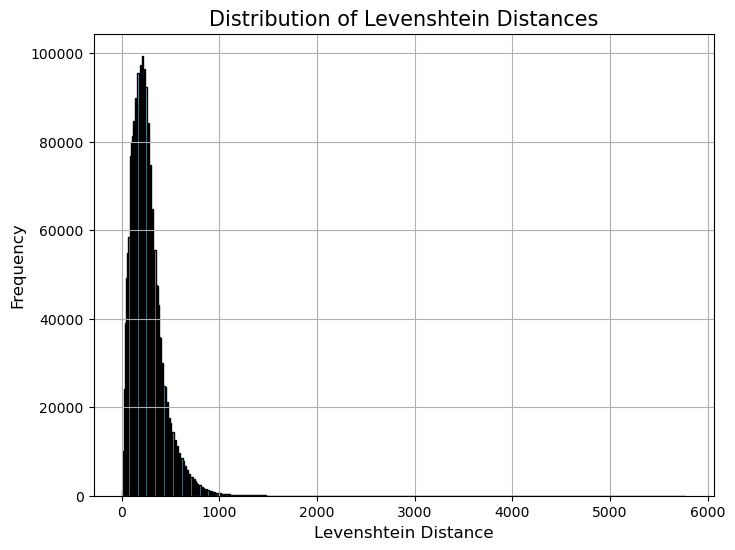

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(df['levenshtein_distance'], bins=500, color='skyblue', edgecolor='black')
plt.title('Distribution of Levenshtein Distances', fontsize=15)
plt.xlabel('Levenshtein Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

In [68]:
# Inspect prompts-resuts combinations with levenstein distance > 1000
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None) 
df[df['levenshtein_distance'] > 1000][['prompt', 'result']].head(10)

,prompt,result
2037029,"Na een carrière als diplomaat (Madrid, Wenen, Berlijn en Parijs, waar hij de Commune van Parijs, de opstand van 1871, meemaakte), was hij journalist, oprichter van kranten (\""La Rassegna\"", eerst een weekblad, en \""Il Giornale d'Italia\"") en socioloog. Hij deed onderzoek naar de situatie van de boeren in zijn geboortestreek in Toscane in 1875. Hij schreef vervolgens een boek met zijn jeugdvriend Leopoldo Franchetti over de levensomstandigheden van de boeren in Sicilië en de politiek-bestuurlijke toestand op het eiland, wat resulteerde in het boek \""La Sicilia nel 1876\"". Tot op de dag van vandaag wordt dat als een standaardwerk beschouwd en het was de eerste serieuze mafiastudie. In 1882 werd Sonnino als afgevaardigde in het parlement gekozen voor de conservatief-liberalen. In 1893 werd hij minister van Financiën en saneerde hij de volledige staatsschuld. Later was hij tweemaal kortstondig, in 1906 en 1909/1910, minister-president. In zijn eerste regeringsperiode \""De Honderd Dagen van Sonnino\"" kwam hij met een vergaand hervormingsprogramma: spoorwegnationalisatie, invaliditeitspensioenen, verregaande maatregelen om de kleine boeren in het Zuiden te ondersteunen (belastingverlaging, zaadsubsidies, kredieten en landonteigening), algemeen kiesrecht voor mannen en grote welwillendheid voor een door Maria Montessori aangeboden petitie voor algemeen vrouwenkiesrecht. De oppositie sloot snel de rijen en het enige dat Sonnino voor elkaar heeft gekregen is de afschaffing van de preventieve censuur.","Deze man had een druk leven. Hij werkte over de hele wereld als diplomaat, in steden zoals Madrid, Wenen, Berlijn en Parijs. In Parijs maakte hij een grote opstand mee in 1871. Later werd hij journalist en richtte hij zelfs zijn eigen kranten op. Hij was ook een socioloog en onderzocht hoe boeren leefden in Toscane, de plek waar hij vandaan kwam. Samen met zijn vriend Leopoldo Franchetti schreef hij een belangrijk boek over de situatie van boeren in Sicilië. Dit boek was de eerste serieuze studie over de maffia.\n\nSonnino werd ook politicus. In 1882 kwam hij in het parlement en later werd hij minister van Financiën. Hij zorgde ervoor dat de schulden van de staat werden opgelost. Hij was zelfs twee keer kort minister-president. Tijdens zijn eerste periode als leider probeerde hij veel te veranderen. Hij wilde de treinen van de staat laten zijn, zorgen dat mensen met een handicap pensioen kregen, en kleine boeren helpen met minder belastingen en meer steun. Hij wilde dat alle mannen mochten stemmen en stond open voor het idee dat vrouwen ook mochten stemmen. Maar de andere politici waren het niet met hem eens en het enige wat hij echt kon veranderen, was het stoppen van censuur voordat iets gepubliceerd werd."
1054548,"Aan het einde van de jaren zestig sloot hij zich aan bij de Kampucheaanse Revolutionaire Volkspartij en bij haar militaire vleugel, de Rode Khmer. Sinds 1970 was hij tevens een geheim agent van koning Norodom Sihanouk om de pro-Amerikaanse regering van Lon Nol te bevechten. Hij klom op tot brigadier in de Rode Khmer. In 1975 nam de Rode Khmer de macht over. Nadat de Rode Khmer begon aan haar massaslachtingen, ging Hun Sen naar Vietnam. In 1979 viel Vietnam Cambodja aan om het te bevrijden van de Rode Khmer. Hun Sen keerde in het kielzog van de Vietnamezen naar Cambodja terug en werd minister van Buitenlandse Zaken (1979-1986; 1987-1990) en vicepremier. In 1985 werd hij minister-president. In april 1989 kondigde hij de terugtrekking van het Vietnamese leger aan. Na de vier jaar durende onderhandelingen tussen de Cambodjaanse regering en de regering in ballingschap van prins Norodom Sihanouk, mocht de laatste in 1991 naar Cambodja terugkeren en werd Sihanouk staatshoofd. Hun Sen bleef premier. Hoewel hij niet voldoende stemmen vergaarde bij de verkiezingen van 1993, weigerde hij af te treden. De impasse werd doorbroken en er werd een co-premierschap ingesteld: Hun Sen bleef premier, maar kreeg 

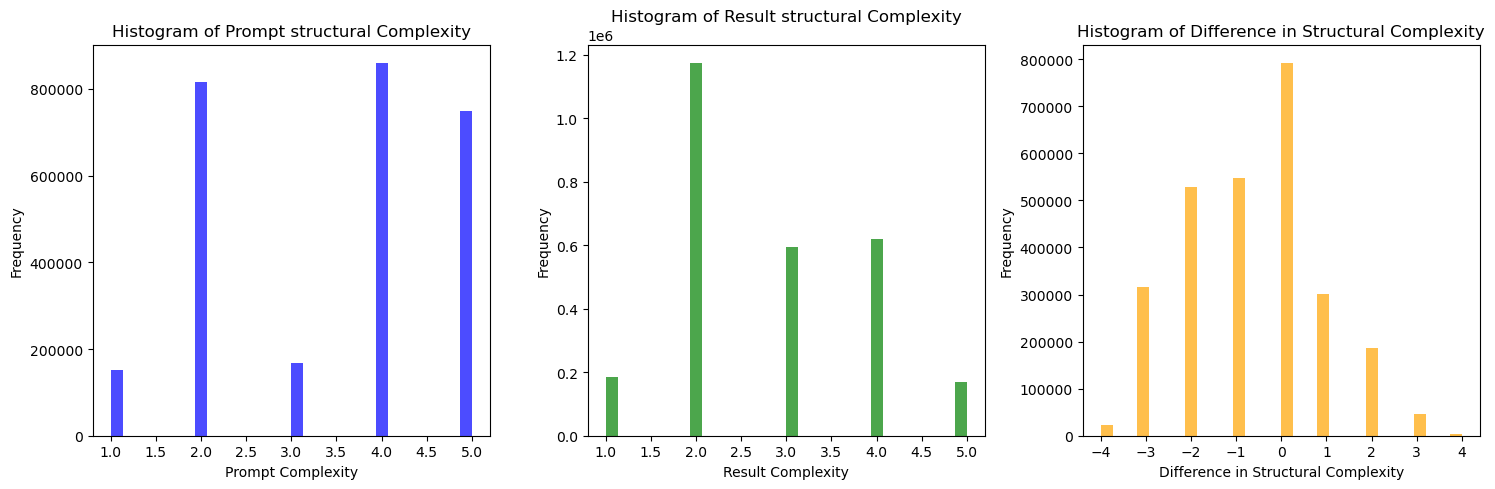

In [70]:
# Set up the figure and axes
plt.figure(figsize=(15, 5))

# Histogram for prompt_complexity
plt.subplot(1, 3, 1)
plt.hist(df["prompt_complexity"], bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Prompt structural Complexity")
plt.xlabel("Prompt Complexity")
plt.ylabel("Frequency")

# Histogram for result_complexity
plt.subplot(1, 3, 2)
plt.hist(df["result_complexity"], bins=30, color='green', alpha=0.7)
plt.title("Histogram of Result structural Complexity")
plt.xlabel("Result Complexity")
plt.ylabel("Frequency")

# Histogram for dif_structural_complexity
plt.subplot(1, 3, 3)
plt.hist(df["dif_structural_complexity"], bins=30, color='orange', alpha=0.7)
plt.title("Histogram of Difference in Structural Complexity")
plt.xlabel("Difference in Structural Complexity")
plt.ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [71]:
# Function to compute the similarity score (difference) between prompt and result
# Load the sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def similarity_score(prompt, result):
    embeddings = model.encode([prompt, result])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    # Inverse similarity to make higher differences yield higher complexity
    return 1 - similarity

In [73]:
df = df.iloc[:10000]
df['similarity_complexity'] = df.apply(lambda row: similarity_score(row['prompt'], row['result']), axis=1) #alles duurt meer dan 1,5 uur
# 10000 duurt 

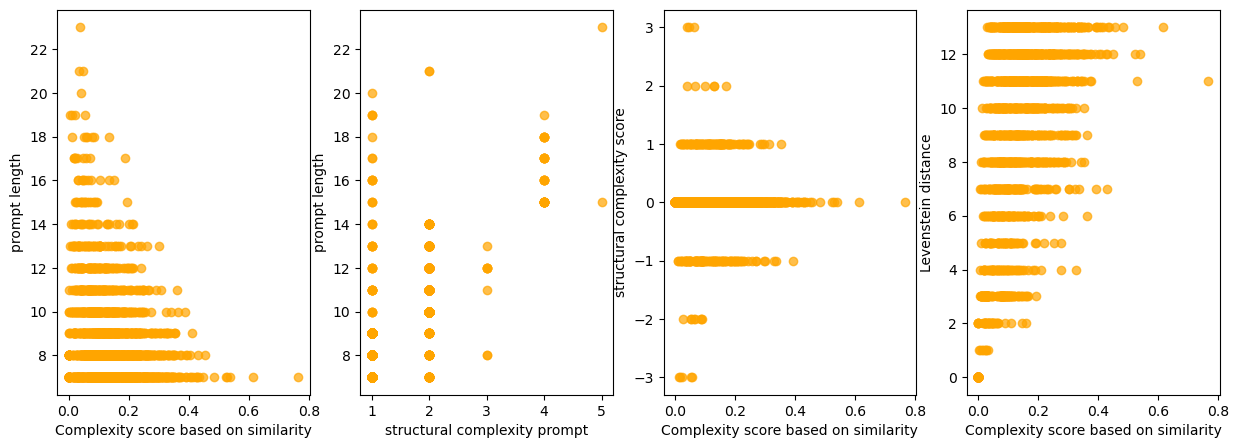

In [75]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)

plt.scatter(df["similarity_complexity"], df["prompt_lenght"], color='orange', alpha=0.7)
plt.xlabel("Complexity score based on similarity")
plt.ylabel("prompt length")

plt.subplot(1, 4, 2)
plt.scatter(df["prompt_complexity"], df["prompt_lenght"], color='orange', alpha=0.7)
plt.xlabel("structural complexity prompt")
plt.ylabel("prompt length")

plt.subplot(1, 4, 3)
plt.scatter(df["similarity_complexity"], df["dif_structural_complexity"], color='orange', alpha=0.7)
plt.xlabel("Complexity score based on similarity")
plt.ylabel("structural complexity score")

plt.subplot(1, 4, 4)
plt.scatter(df["similarity_complexity"], df["levenshtein_distance"], color='orange', alpha=0.7)
plt.xlabel("Complexity score based on similarity")
plt.ylabel("Levenstein distance")

plt.show()

In [10]:
text = "Baart de la Faille / De la Faille • Baartz • Bachiene • Backer / Backer van Leuven / Huyghens Backer • Backhuijsen / Van de Sande Bakhuijzen • Badon Ghyben • Baelde • Van Baerle • Baert • Bake / De Menthon Bake / Van den Wall Bake • Bakker (Goedereede) • Bakker (Rostock) • Balfour / Balfour van Burleigh • Balguerie • Ballot / Buys Ballot • den Bandt • Banga • Bannier • Banning (geslacht) / Weyn Banningh • Barbas(geslacht) • De Bas • Bastert • Bastiaanse / Van Bouwdijk Bastiaanse / Haak Bastiaanse • Batenburg (geslacht) / Van Basten Batenburg • Battaerd • Baud (geslacht) • Bauduin • De Beaufort • Beaujon • Beausar / Van Breda Beausar • Beckman / Wiardi Beckman • Beeckman • Van Beeftingh • Beelaerts / Beelaerts van Emmichoven / Beelaerts van Blokland • Beeldemaker • Beels • Den Beer Poortugael • van Beest / Van Voorst van Beest • Beets • Van Bemmelen • Benier • Benteyn • Bentfort / Bentfort van Valkenburg / Drossaart Bentfort • Van Berckel • Bère / Lach de Bère • (Van) Berenbroeck • Van den Berg (Dongen) • Van den Berg (geslacht) / Bentz van den Berg / Bland van den Berg / Van Maren Bentz van den Berg • van den Berg (geslacht) / Van den Berg van Saparoea • Berger • Van den Bergh (geslacht) / van den Bergh van Heinenoord • Van Benthem van den Bergh • Bergsma • Berdenis van Berlekom • Bernicke • Bert (geslacht) / de Bert / Schrassert Bert • Besier • Bettink / Wefers Bettink • Betz • Beuker • Van Beuningen • Van Beusekom / Hubert van Beusekom / Doude van Troostwijk • Van Beusekom (Doetinchem) • Beyen • De Beyer • Beyerinck • Beyerman • Beijnen / van Duijfhuijs Beijnen / Koolemans Beijnen • Bichon Vingerhoedt / Bichon Visch / Bichon van IJsselmonde • Bicker / Bicker Caarten • De Bie • Bienema / van Bienema • Bienfait / Bodel Bienfait • Bierman • Van den Biesen / Vongers van den Biesen • Bik (geslacht) / Arnold Bik / Van Berckel Bik / Butin Bik / Mulock van der Vlies Bik / de Nijs Bik / de Perez Bik / Vreede Bik • Bilderdijk • van der Bilt • Binkes • Binkhorst / Binkhorst van Oudcarspel en in Koedijk • Bischoff / Bischoff van Heemskerck / Bischoff Tulleken • Bisdom (geslacht) / Van Lakerveld Bisdom / Reijnders Bisdom / Wijckerheld Bisdom • Blaauw (Stadlohn) • Blaauw (Westzaan) • Blaisse • Blanckenhagen • Blankenheym • Blankert • Bloembergen • Bloemers • Blokhuis • Blokhuyzen • Blom (Delft) • Blom (Eemnes) • Blom (Hindelopen) • Blom (Kleef) • Blom (Oost-Vlaanderen) • Blomhert • van Blommestein • Blussé / Blussé van Oud-Alblas / Van Braam Blussé • Blijdenstein / Blenken Blijdenstein / de Stoppelaar Blijdesteijn • Boddaert • Boddens • Boden (patriciaatgeslacht) • Boelen /Bohlen • van Boelens • Boellaard • Boerlage • Boeye • Bogaers • Bogaert • Nering Bögel • Böhtlingk • Du Bois • Boissevain • Bok • Boll • Bolomey • Bondam • Bonebakker • Bongaert • Bonnike • Boogaert • Boom (geslacht) / Isebree Boom / De Lange Boom / Plevier Boom • Boomkamp / van Leeuwen Boomkamp • Boon (Rotterdam) • Boon (geslacht) / Boon Hartsinck • Boon / Boon van Ostade • Boonacker • Boonen • Boot (geslacht) / Moerkerk Boot / Nagtglas Boot • De Booij • Van Bommel van Vloten • De Bordes / Van Walré de Bordes • Borgesius / Zuiderveen Borgesius (eerste geslacht) • Borgesius (tweede geslacht) • Borleffs • Von dem Borne • Borret • Borski (geslacht) † / Van Noord Borski / Van Wieringhen Borski • Bosch • Ten Bosch (geslacht) • Van den Bosch (Breda) • Van den Bosch (Rheden) • Van den Bosch (Rotterdam) • Bosscha • van Bosse • Boumeester / Van Oldenbarneveld Boumeester • Bouricius / Visscher Bouricius • Boutmy • Bouvin • Bouvy • Bouwensch • Braakenburg / Brakenburg • Van Braam / Van Braam Houckgeest • Van Braam van Vloten • Braams • Van Brakel • Brandt • Brants • Brantsma / Willinge Brantsma • De Brauw / Ten Noever de Brauw / Stavenisse de Brauw • Bredius / Klinkhamer Bredius † • Breekpot • Van der Breggen / Van der Breggen Paauw • Breukelman • Briët / de la Saussaye Briët • van den Brink / Bakhuizen van den Brink • Van den Broecke / De Smit van den Broecke • Van den Broek (Geulle) / Van den Broek d' Obrenan • Van den Broek (Babyloniënbroek) • Vun den Broeke • Broers • Broese (geslacht) / Broese van Groenou • Le Bron de Vexela • Brongersma • Bedloo de Bronovo • Brousson / Clockener Brousson • Reeling Brouwer • Browne • Van der Brugghen • Brugma • Bruinier • Bruins • Brutel de la Rivière • Bruijn / Bruijn van Rozenburg / Van der Horst Bruijn / Van Oosterwijk Bruijn • De Bruyn (Herpen) • De Bruyn / De Bruin ('s-Hertogenbosch) • De Bruyn (Kockengen) • De Bruyn / De Bruyn van Melis- en Mariekerke • de Bruyn / Van Troostenburg de Bruyn / Lobry van Troostenburg de Bruyn † • Bruijns / Mörzer Bruijns • Büchler • Buck • Budde / Cost Budde • Buma / De Blocq van Haersma Buma † / Van Haersma Buma / Hopperus Buma / Hora Buma • Bunge • Buning / De Cock Buning / Werumeus Buning • Van Buren • Burger • Burkens • Buschkens • Busmann / Hartman Busmann / Star Busmann / Tjaden Busmann • Bussemaker (Emlichheim) • Bussemaker (Hengelo) / Barlagen Bussemaker • Buteux • Buyskes • Bybau • De Bye / Thierry de Bye • Van Bijlert • Bijleveld (Rhoon) • Bijleveld (Westfalen) / Van Eijk Bijleveld • Bijvoet (geslacht) / Van Dieren Bijvoet"
# gives ration 0.63
def is_list_like(text):
    # Regex to find non-word, non-space characters
    non_word_chars = re.findall(r'[^\w\s]', text)
    # Split text into words
    words = re.findall(r'\w+', text)
    
    # Calculate ratio: number of non-word chars to words
    ratio = len(non_word_chars) / len(words) if len(words) > 0 else 0
    
    # You can adjust this threshold based on your data
    return ratio > 0.5

test = is_list_like(text)
print(test)

True
